installing/upgrade fastai package

In [44]:
from IPython.utils import io
with io.capture_output() as captured:
  !pip install --upgrade fastai==2.0.13

Import and verify

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)

from fastai.vision.all import *

1.6.0+cu101
True
2.0.13


### Downloading the dataset 

In [3]:
path = untar_data(URLs.CAMVID_TINY, dest="./Data")

In [4]:
path.ls()

(#3) [Path('Data/camvid_tiny/codes.txt'),Path('Data/camvid_tiny/images'),Path('Data/camvid_tiny/labels')]

In [5]:
codes = np.loadtxt(path/'codes.txt',dtype = str)

In [6]:
images = get_image_files(path/'images')
labels = get_image_files(path/'labels')

In [7]:
print(images[4],labels[4])

Data/camvid_tiny/images/0016E5_00840.png Data/camvid_tiny/labels/Seq05VD_f01830_P.png


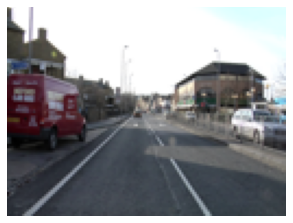

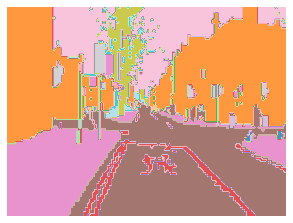

In [8]:
img = PILImage.create(images[4])
mask = PILMask.create(labels[4])
img.show(figsize = (5,5))
mask.show(figsize = (5,5), alpha = 0.8)

Creating the tensor matrix(?)

In [9]:
tensor(mask)

tensor([[ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        ...,
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17]], dtype=torch.uint8)

We use to tensor to check that we've loaded up the correct image and data

In [10]:
codes[19],codes[4],codes[26]

('Sidewalk', 'Building', 'Tree')

### Creating a function to get images from file

In [11]:
def label_fn(filename): return path/'labels'/f'{filename.stem}_P{filename.suffix}'

## Loading the data

In [12]:
camvid = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), #We specify input image and output as masks 
                   get_items = get_image_files,
                   get_y = label_fn,
                   splitter = RandomSplitter(valid_pct=0.2, seed = 100134),
                   item_tfms = RandomResizedCrop(size = 480),
                   batch_tfms = {*aug_transforms(size = 128), Normalize.from_stats(*imagenet_stats)})

In [13]:
data = camvid.dataloaders(path/'images', bs = 8, num_workers=0)

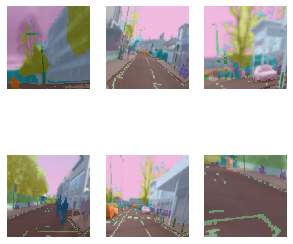

In [14]:
data.show_batch(max_n=6, figsize = (5,5))

In [15]:
x,y = data.one_batch()
x.size(), y.size()

(torch.Size([8, 3, 128, 128]), torch.Size([8, 128, 128]))

In [16]:
code_to_idx = {k:v for v,k in enumerate(codes)}

In [17]:
code_to_idx

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

What to do with void code(?)

In [18]:
void_code = code_to_idx['Void']
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim = 1)[mask]==targ[mask]).float().mean()

## Creating an architecture/Learning model

In [19]:
learn = unet_learner(data, resnet34, metrics = [acc_camvid])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Finding the best learning rate

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0003311311302240938)

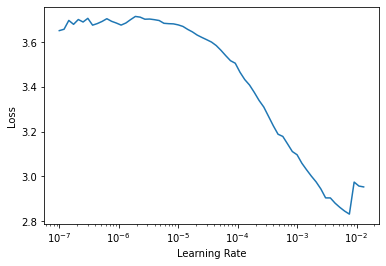

In [20]:
learn.lr_find()

In [21]:
lr = 1e-2
learn.fit_one_cycle(5, max_lr = lr)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.947331,2.337072,0.375622,00:06
1,2.406968,1.685016,0.598817,00:04
2,2.041402,1.325033,0.664382,00:04
3,1.849815,1.342753,0.652122,00:04
4,1.681249,1.296218,0.663886,00:04


Saving our model

In [22]:
learn.save('Stage-1')

Path('models/Stage-1.pth')

### Visualising the performance of our model - predicted vs actual segmented masks

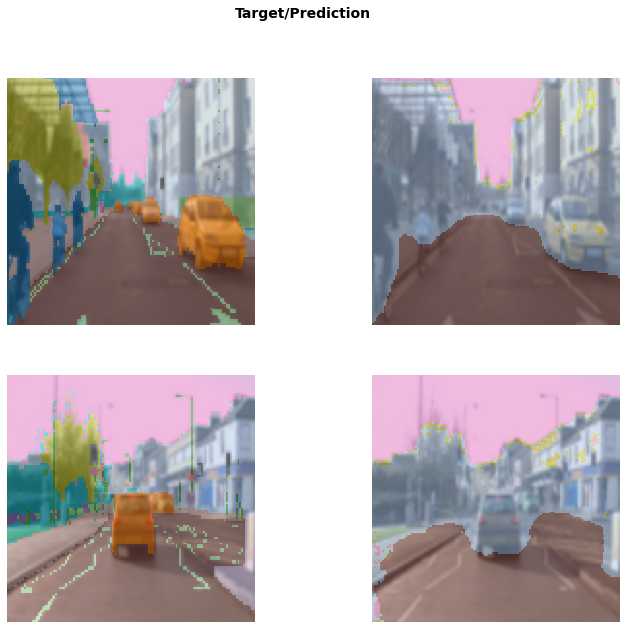

In [23]:
learn.show_results(max_n= 4, figsize = (12,10))

We Unfreeze the convolution layer parameters - where edge detection and all take place, unfreeze for fine-tuning purpose

In [24]:
learn.unfreeze() 

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=6.309573450380412e-07)

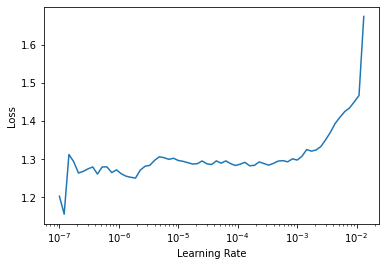

In [25]:
learn.lr_find()

In [26]:
lr = 1e-3
learn.fit_one_cycle(5, max_lr = lr)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.363632,1.845288,0.476418,00:04
1,1.402973,1.574293,0.618289,00:04
2,1.378216,1.213285,0.667804,00:04
3,1.314101,1.074118,0.700983,00:04
4,1.239167,1.072450,0.703732,00:04


In [27]:
learn.save('Stage-2')

Path('models/Stage-2.pth')

In [28]:
learn.load('Stage-2')

## Testing 

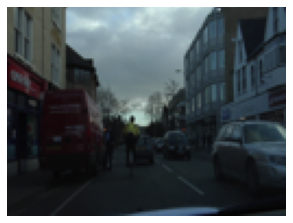

In [29]:
test_img = PILImage.create(images[14])
test_img.show(figsize = (5,5))

In [30]:
preds = learn.predict(test_img)

In [31]:
preds[0]

TensorMask([[ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]])

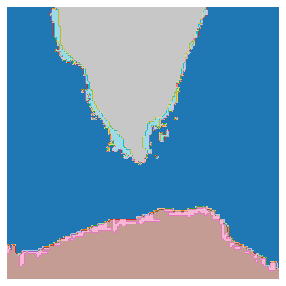

In [32]:
mask_predicted = PILMask.create(preds[0])
mask_predicted.show(figsize = (5,5),alpha = 1)

Applying similar learning approach for augumentation size of 320 

In [33]:
camvid = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), #We specify input image and output as masks 
                   get_items = get_image_files,
                   get_y = label_fn,
                   splitter = RandomSplitter(valid_pct=0.2, seed = 100134),
                   item_tfms = RandomResizedCrop(size = 460),
                   batch_tfms = {*aug_transforms(size = 320), Normalize.from_stats(*imagenet_stats)})

In [34]:
data_320 = camvid.dataloaders(path/'images', bs = 4,num_workers=0)

In [35]:
learn.dls = data_320

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=9.12010818865383e-07)

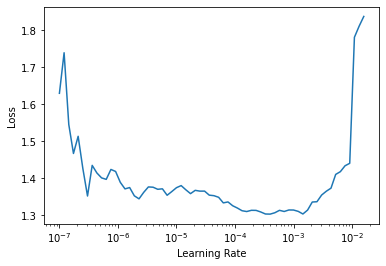

In [36]:
learn.lr_find()

In [37]:
lr = 1e-7
learn.fit_one_cycle(5,max_lr = slice(lr, lr/10))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.223864,1.482079,0.586805,00:19
1,1.402235,1.404793,0.662465,00:19
2,1.374293,1.364800,0.699712,00:19
3,1.307702,1.077818,0.716294,00:19
4,1.253981,1.062260,0.724359,00:19


In [38]:
learn.save('Stage-3')

Path('models/Stage-3.pth')

In [39]:
preds = learn.predict(test_img)

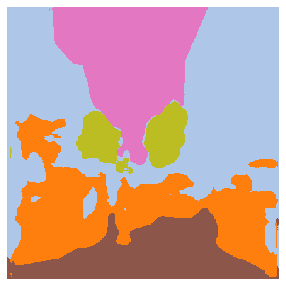

In [40]:
preds[0].show(figsize = (5,5),alpha = 1)